![](img/563_banner.png)

# Lecture 3: Introduction to Principal Component Analysis (PCA)

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan and learning outcomes

### Lecture plan 

- Introduction (~5 mins)
- Summary of the pre-watch videos (~15 mins)
- In-class activities and Q&A (~10 mins)
- Break (~5 mins)
- PCA applications (~30 mins)
- Final comments, summary, and reflection (~10 mins)


### Imports 

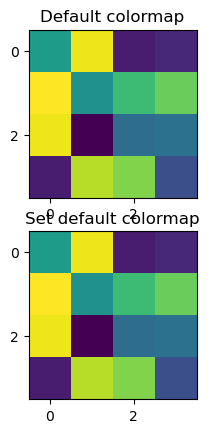

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath("."), "code"))

import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import *
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5, 4)
# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

### Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- Explain some issues caused by high-dimensional data and the need for dimensionality reduction.
- Explain the intuition behind Principal Component Analysis (PCA). 
- Describe the role and shapes of four matrices $X$, $W$, $Z$, and $\hat{X}$ in the context of dimensionality reduction techniques;
- Explain how to get $Z$ from $X$ and $W$. 
- Explain how to get $\hat{X}$ from $Z$ and $W$. 
- State the loss function of PCA. 
- Explain the difference between PCA and linear regression. 
- Broadly explain how PCA is learned using SVD. 
- Explain how PCA can be used in data compression, better representation, and visualization.  
- Use `sklearn.decomposition.PCA` to perform Principal Component Analysis. 
- Use sklearn's `inverse_transform` to get reconstructions. 

<br><br><br><br>

## Dimensionality reduction: Motivation and introduction [[video](https://youtu.be/r-DwXpg1YDI)]

- Suppose you're shown the picture below and you are told that this is **Eva**. 
- Do you have to remember every pixel in the image to recognize other pictures of Eva? 

![](img/eva-tree.jpg)

- For example, if you are asked which one is Eva in the following pictures, it'll be fairly easy for you to identify her just based on some high-level features. 

![](img/hello-bmjs.png)

 

- Just remembering important features such as shape of eyes, nose, mouth, shape and colour of hair etc. suffice to tell her apart from other people. 
- Can we learn such high-level features or **the summary** of the given raw features with machine learning models?
- Yes! With dimensionality reduction techniques! 
- As data scientists, given a dataset we either want to understand some phenomenon or build predictive models. 
- Very often the data we work with is clouded, complex, unclear, or even redundant.
- But in reality the underlying phenomenon we are trying to understand or the relationship between variables in the data is much simpler. 
- Dimensionality reduction is useful in such scenarios.  

### Toy example: nutritional value of pizzas

- Suppose we want to analyze nutritional value of pizzas of different brands. 
- Here is a [toy dataset](https://www.kaggle.com/shishir349/can-pizza-be-healthy) for this problem. 

In [2]:
pizza_df = pd.read_csv("data/pizza.csv")
pizza_df.head()

brand     id   mois   prot    fat   ash  sodium  carb   cal
0  A     14069  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  A     14053  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  A     14025  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  A     14016  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  A     14005  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [3]:
X_pizza = pizza_df.drop(columns=["id", "brand"])
y_pizza = pizza_df["brand"]
X_pizza.head()

mois   prot    fat   ash  sodium  carb   cal
0  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [4]:
X_pizza.shape

(300, 7)

We have features such as amount of moisture, amount of protein, amount of fat, amount of ash, amount of sodium, and amount of carbohydrates, and amount of calories per 100 grams in the dataset.     

Let's examine correlations between different variables. 

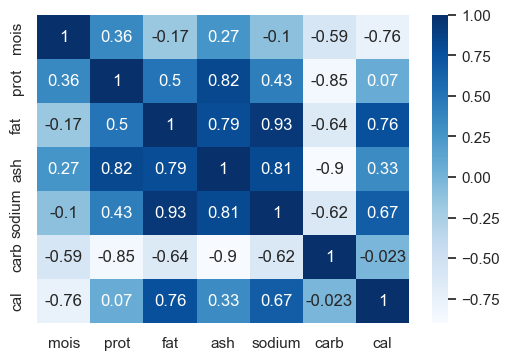

In [5]:
corr_heatmat(X_pizza.corr(), w=6, h=4)
plt.show();

- There is redundancy in the data; many features are correlated.  
- Can we **summarize** these features in some meaningful way so that the data is cleaner and less redundant?
- Can we just discard some redundant features? 
- We have seen some (not very satisfactory) feature selection methods to identify least important features in a greedy way and throw away such features.
- This week we are going to look at a class of more sophisticated approaches for this, which are typically referred to as **dimensionality reduction**.  

### What is dimensionality reduction? 

**Dimensionality reduction** is the task of summarizing data or reducing a dataset in high dimension (e.g., 1000) to low dimension (e.g., 10) **while retaining the most "important" characteristics of the data.** 

**Dimensionality reduction** is also used to reduce the dimensionality similar to feature selection. But
- We will not be just dropping columns as we did in feature selection. 
- The idea of (linear) dimensionality reduction is to project high dimensional data to low dimensional space  while retaining the most "important" characteristics of the data. 
- We can also **reconstruct** the original data (with some error) from this transformed data.

### How do we reduce the dimensions?

- The techniques we are going to look at this week summarize the data by creating new features which are **linear combinations of the original features**. 
- Example:
- 
$$\text{new_feature} = 0.44 \times fat + 0.47 \times ash - 0.42 \times carb \dots$$

### Dimensionality reduction toy example

- Let's apply a popular dimensionality reduction technique called Principal Component Analysis (PCA) using [`sklearn`'s `PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on our nutritional value of pizzas toy data. 
- Learning a PCA model and transforming data is similar to applying preprocessing transformations in `sklearn`. 
- You can learn a PCA model and transform the data using `fit` and `transform` methods, respectively. 

In [6]:
n_components = (
    2  # summarize the data with only two features (typically called components)
)
pipe_pca = make_pipeline(
    StandardScaler(), PCA(n_components=n_components)
)  # scaling before PCA is crucial. We'll see the reason later.
Z = pipe_pca.fit_transform(X_pizza)  # transform the data

How does the data look like after dimensionality reduction? 

In [7]:
Z_labels = ["Z" + str(i + 1) for i in range(n_components)]
pd.DataFrame(Z, columns=Z_labels, index=X_pizza.index).head()

Z1        Z2
0  5.010343  2.679215
1  5.023755  2.529295
2  4.805439  2.673700
3  4.469543  2.285029
4  4.471893  2.159152

- We have reduced dimensionality from original 7 features to 2 features. 
- The two new features can be thought of as the **summary** of the original features. 

### What has it learned?

- It has learned the "most informative" linear combinations of the features. 
- Each new feature (principal component) has a coefficient associated with each of the original features and the value of the new feature is a linear combination of the original features.   

In [8]:
W_labels = ["PC" + str(i + 1) for i in range(n_components)]
W = pipe_pca.named_steps["pca"].components_
pd.DataFrame(W, columns=X_pizza.columns, index=W_labels)

mois      prot       fat      ash    sodium      carb       cal
PC1  0.064709  0.378761  0.446666  0.47189  0.435703 -0.424914  0.244487
PC2 -0.628276 -0.269707  0.234379 -0.11099  0.201662  0.320312  0.567458

$$\text{Z1} = 0.064709 \times \text{mois} + 0.378761 \times \text{prot} + \dots + -0.424914 \times \text{carb} +  0.244487 \times \text{cal}$$

$$\text{Z2} = -0.628276 \times \text{mois} + -0.628276 \times \text{prot} + \dots + 0.320312 \times \text{carb} +  0.567458 \times \text{cal}$$

In [9]:
np.round(Z[0, :], 4)  # transformed values for the 0th example

array([5.0103, 2.6792])

In [10]:
x0_scaled = pipe_pca.named_steps["standardscaler"].transform(X_pizza)[0, :]
np.round((np.dot(x0_scaled, W[0, :]), np.dot(x0_scaled, W[1, :])), 4)

array([5.0103, 2.6792])

In [11]:
plot_pca_w_vectors(W, W_labels, X_pizza.columns, width=800, height=800)

### How good is the summary? 

- We can look at how much information from the original dataset these two newly created dimensions have captured. 

In [12]:
pipe_pca.named_steps["pca"].explained_variance_ratio_.sum()

0.9231770406002873

We are capturing 92.31% of the information using only two of these newly created features!!  

Let's look at how much "information" we can capture with different number of components. 

In [13]:
n_components = len(X_pizza.columns)
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7))])

In [14]:
df = pd.DataFrame(
    data=np.cumsum(pipe_pca["pca"].explained_variance_ratio_),
    columns=["variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

In [15]:
simple_bar_plot(
    x=df.index.tolist(),
    y=df["variance_explained (%)"],
    x_title="n_components",
    y_title="variance explained (%)",
)

So the first two components summarize most of the information (92.31%) in the data!! 

### Common use cases for dimensionality reduction 

Overall this idea of summarizing the data in a meaningful way is going to be super useful and there are tons of applications for this. 

- **Data compression**    
- **Feature extraction** in a machine learning pipeline 
    - Last week, we created PCA representation of face images before passing it to K-Means clustering. 
- **Visualization**
    - Last week, we carried out dimensionality reduction using PCA to visualize our high dimensional data.
- **Anomaly detection**
- ...

### Dimensionality reduction techniques 

We'll talk about the following linear dimensionality reduction techniques. 

- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (in detail)
- [TuncatedSVD or Latent Semantic Analysis (LSA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (brief discussion)
- [Non-negative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) (brief discussion)

All these techniques can be viewed as applying transformations or "change of basis". 

<br><br><br><br>

## Principal Component Analysis (PCA): Intuition and terminology [[video](https://youtu.be/33TRSSuzALw)]

- PCA has been around for more than 100 years and is one of the most widely used dimensionality reduction techniques. 
- Examples:  
    - [The Big Five personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits) (extroversion, agreeableness, conscientiousness, neuroticism, openness to experience) were discovered using PCA. 

### Hockey-stick curve of global warming 

The famous hockey-stick curve of global warming was created by applying PCA on various temperature-related time series (tree rings, ice cores, etc.). [Source](https://www.wsj.com/articles/SB110834031507653590).

![](img/climate-change-hockey.gif)

<!-- <img src="img/climate-change-hockey.gif" alt="" height="300",width="300">  -->


### PCA intuition

- PCA summarizes the data by finding linear combinations of features. 
- In fact, PCA finds the **best linear combinations** of the original features so that 
    - the first component has the most information 
    - the second component has the second most information 
    - and so on 
- What do we mean by finding the best linear combinations?    

### Do we need two dimensions to describe these data points? 

- Let's create some synthetic data with two dimensions: $x_1$ and $x_2$   

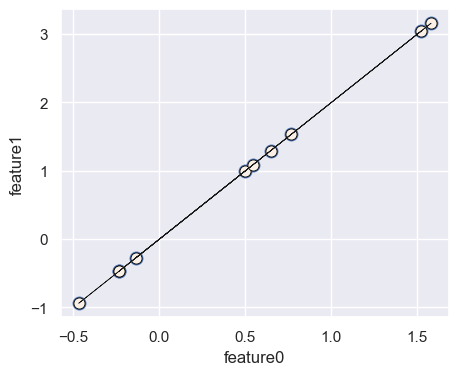

In [16]:
np.random.seed(42)
x1 = np.random.randn(10)
x2 = 2 * x1
X = np.stack([x1, x2], axis=1)

discrete_scatter(X[:, 0], X[:, 1])
plt.scatter(X[:, 0], X[:, 1], linewidths=4)
plt.plot(x1, x2, c="k", linewidth=0.5)
plt.xlabel("feature0")
plt.ylabel("feature1");

### Data with some noise

In [17]:
np.random.seed(42)
x1 = np.random.randn(10)
x2 = x1 + np.random.randn(10) / 3
X_orig = np.stack([x1, x2], axis=1)
X = StandardScaler().fit_transform(X_orig)

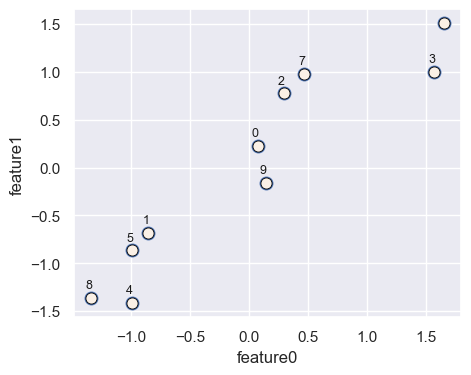

In [18]:
discrete_scatter(X[:, 0], X[:, 1], label_points=True, x1_annot=-0.05, x2_annot=0.1)
plt.scatter(X[:, 0], X[:, 1], linewidths=4)
plt.xlabel("feature0")
plt.ylabel("feature1");

We are using numbers to keep track of different points.

### Feature selection scenario

- What would happen if we drop feature1? 

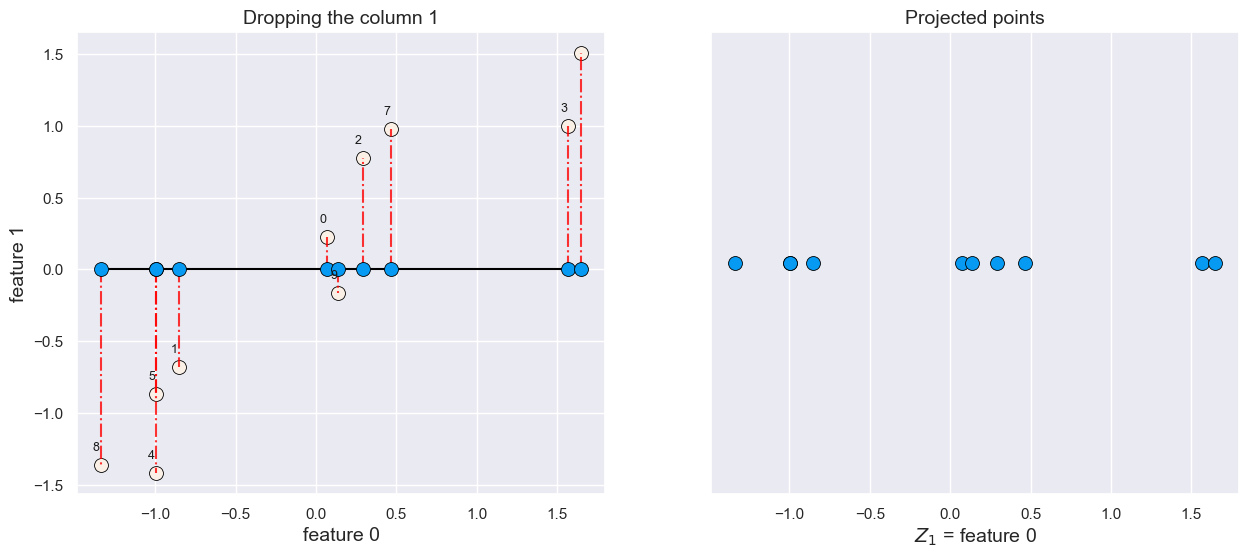

In [19]:
plot_feature_selection(X, drop=1)

- All points are projected on the feature 0 axis. 
- What would happen if we drop feature 0? 

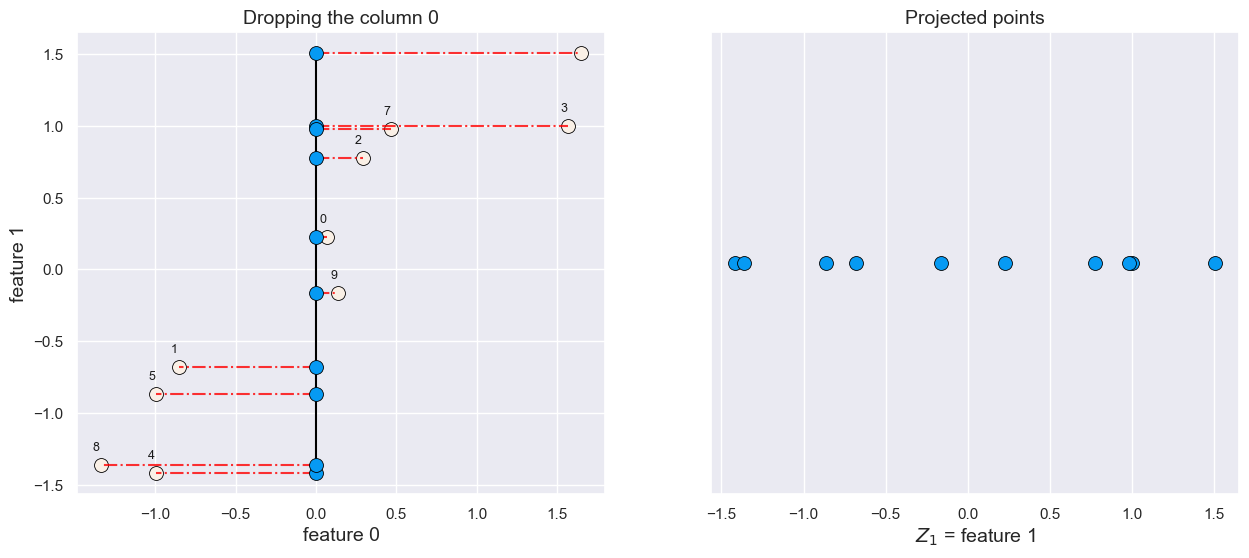

In [20]:
plot_feature_selection(X, drop=0)

All points are projected on the feature1 axis. 

### PCA idea

- How about finding an optimal line going through these points and projecting our data points on this line? 


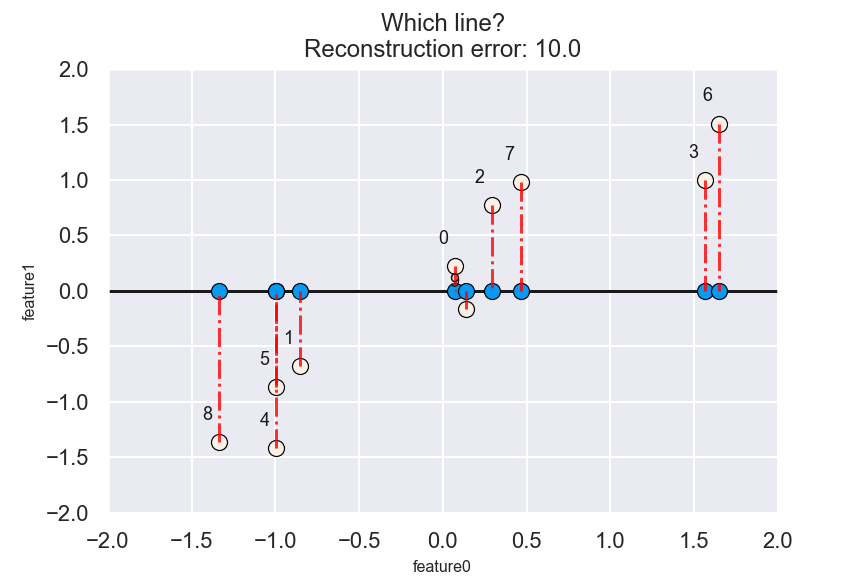
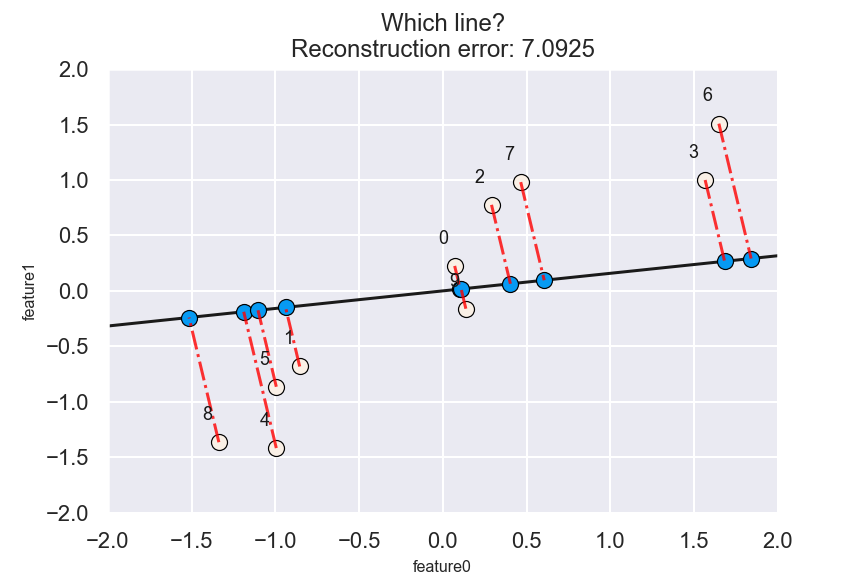
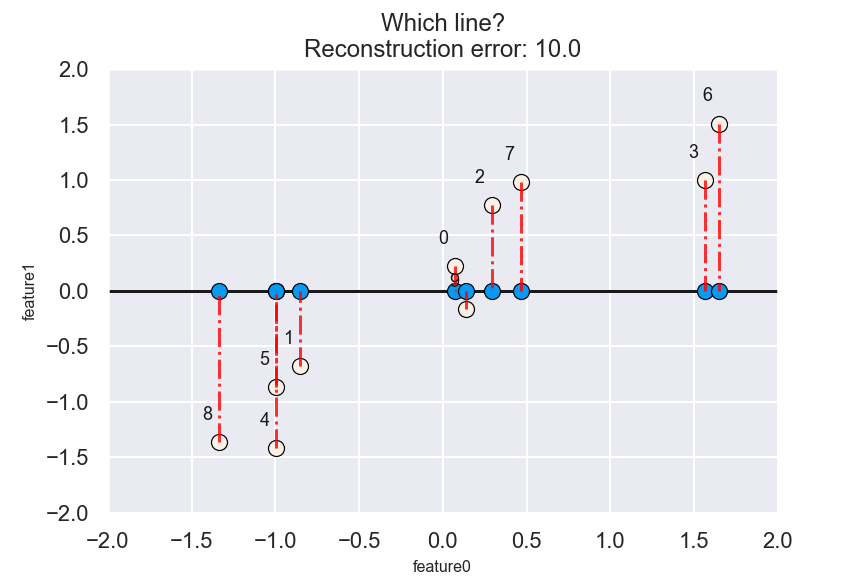
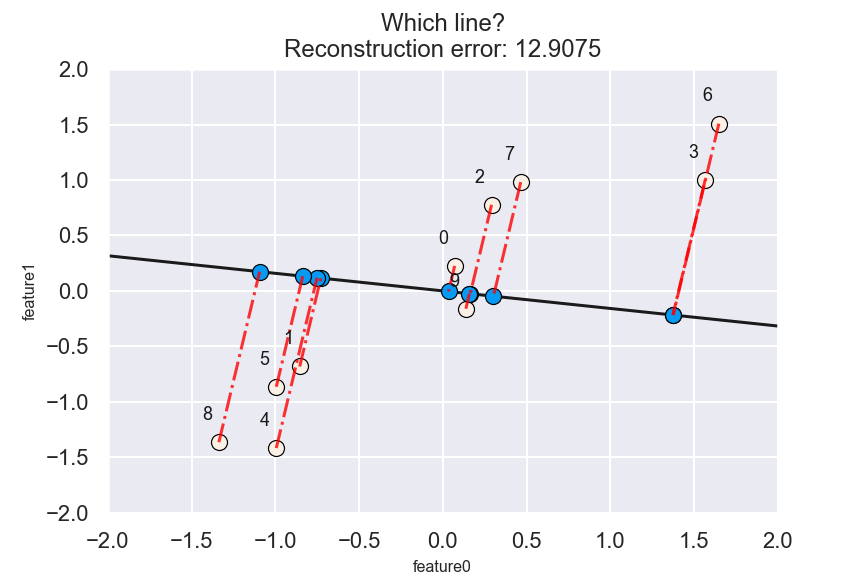
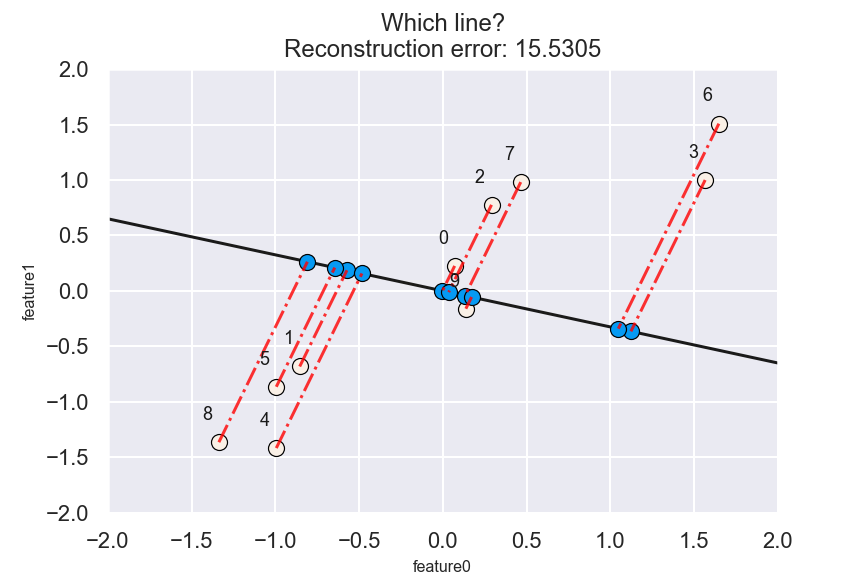
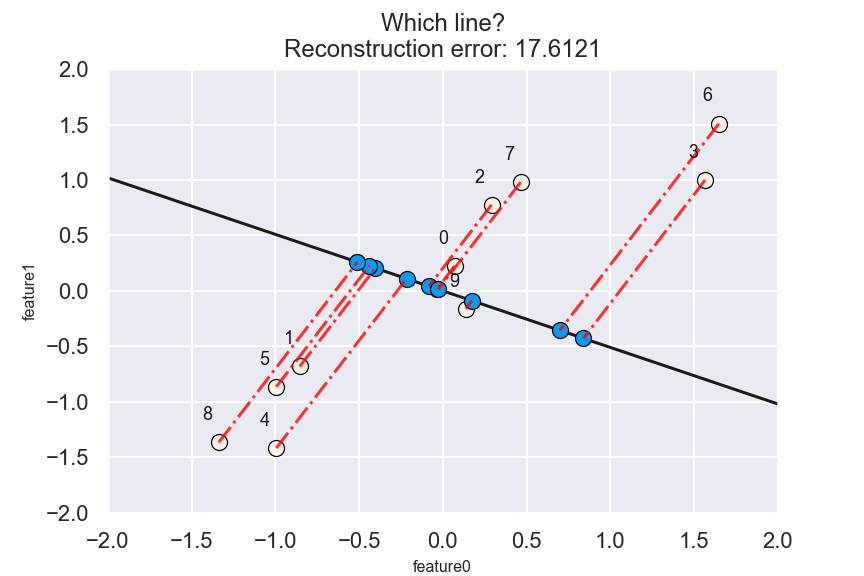
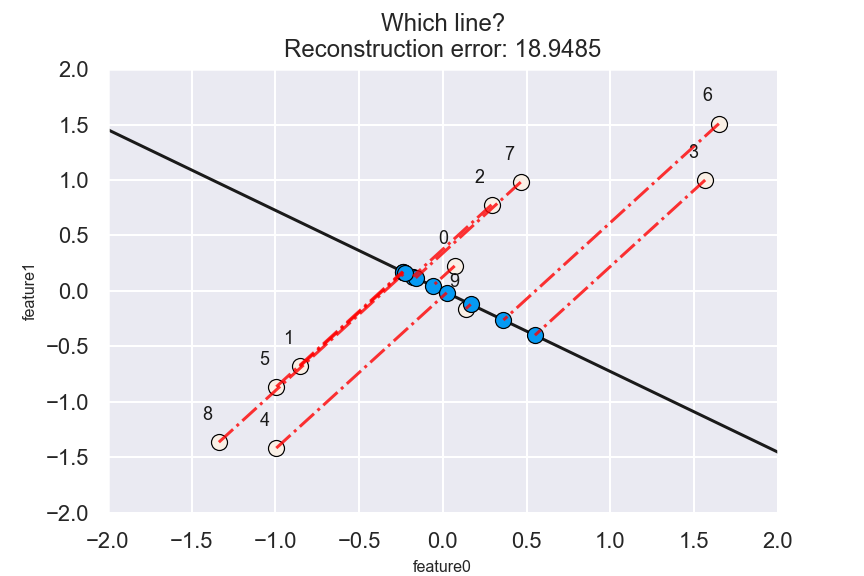
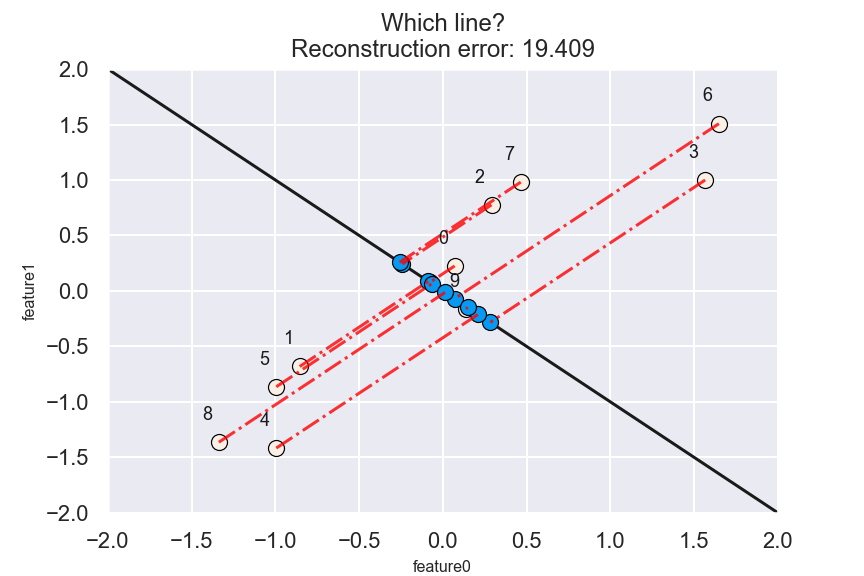
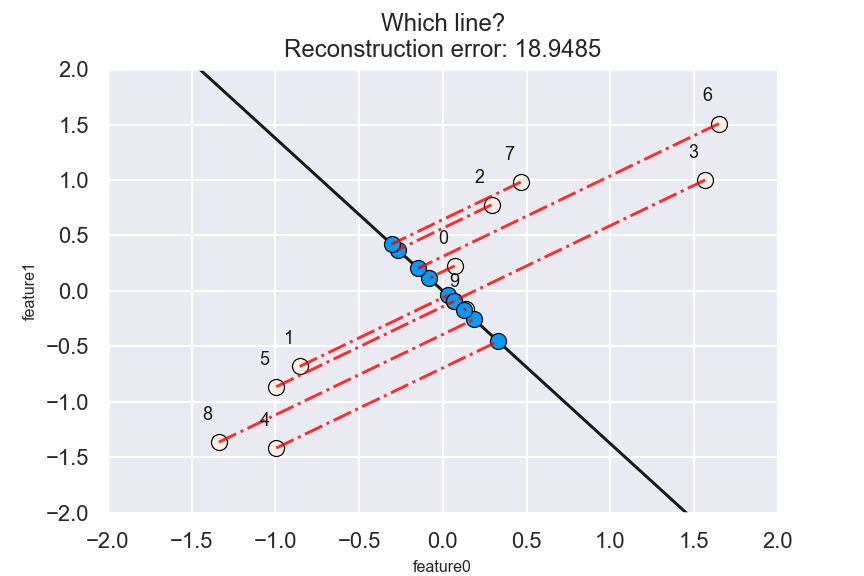
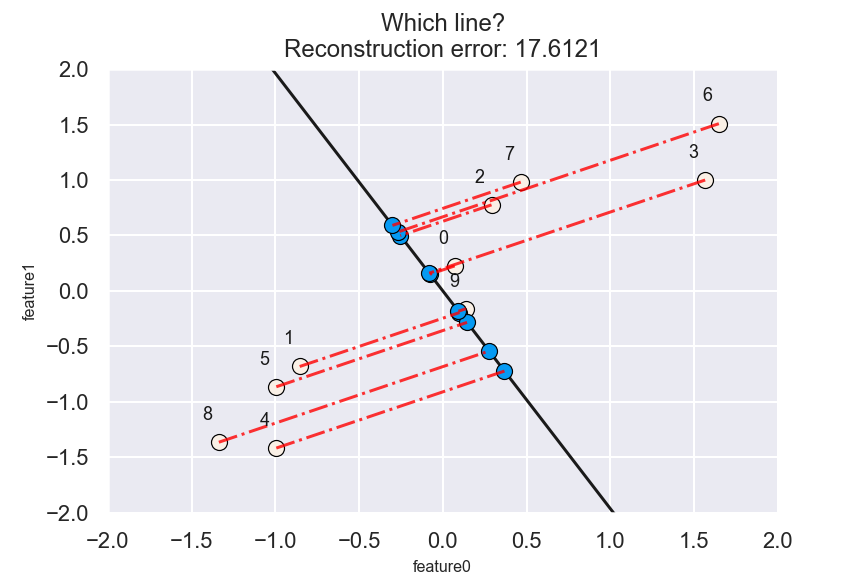
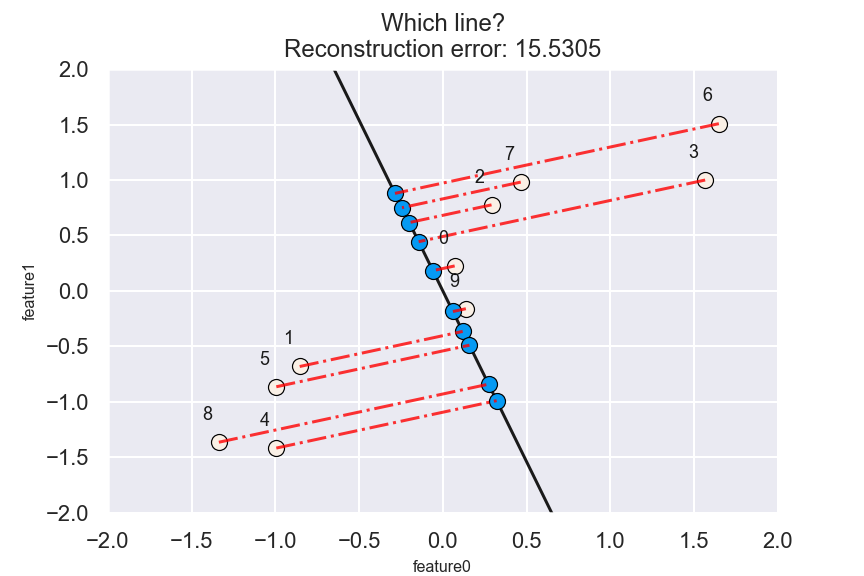
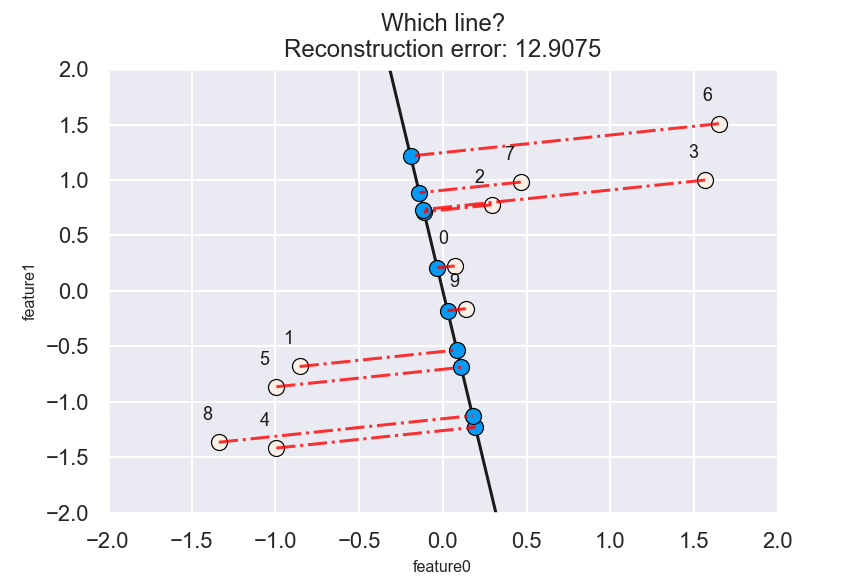
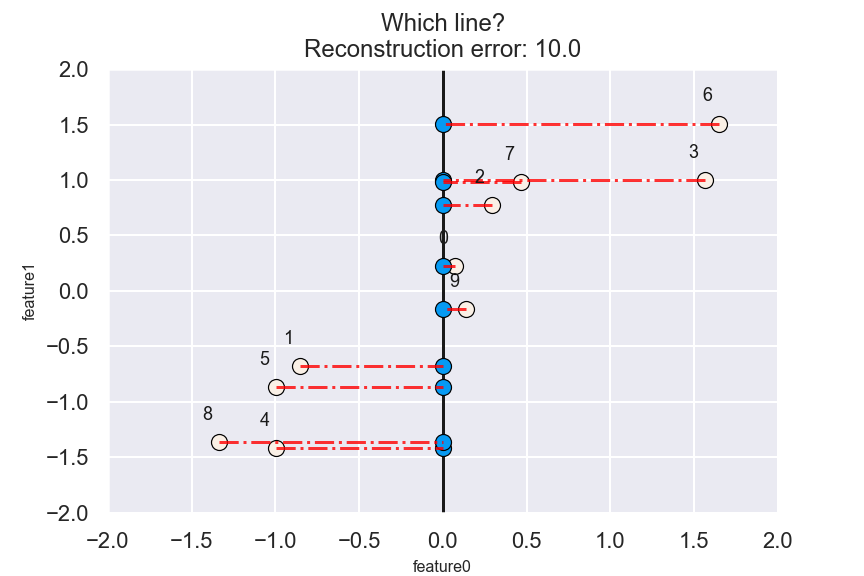
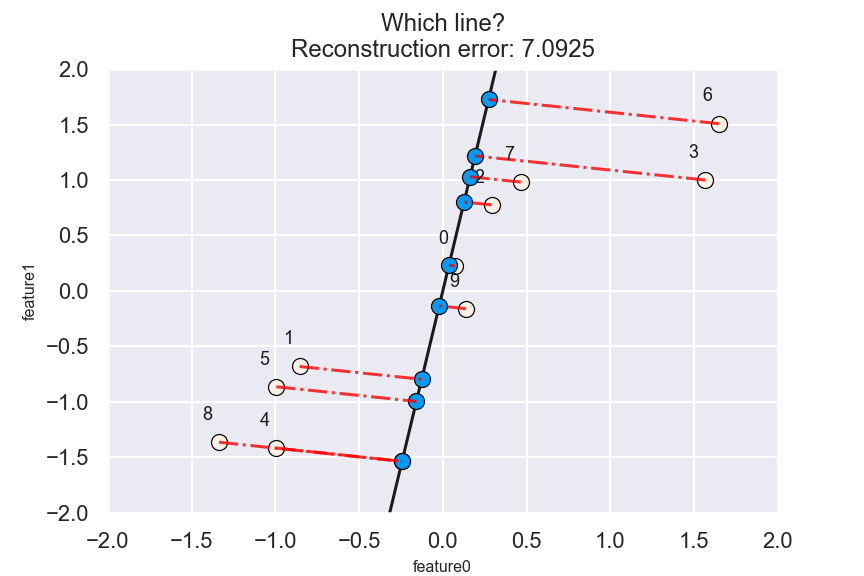
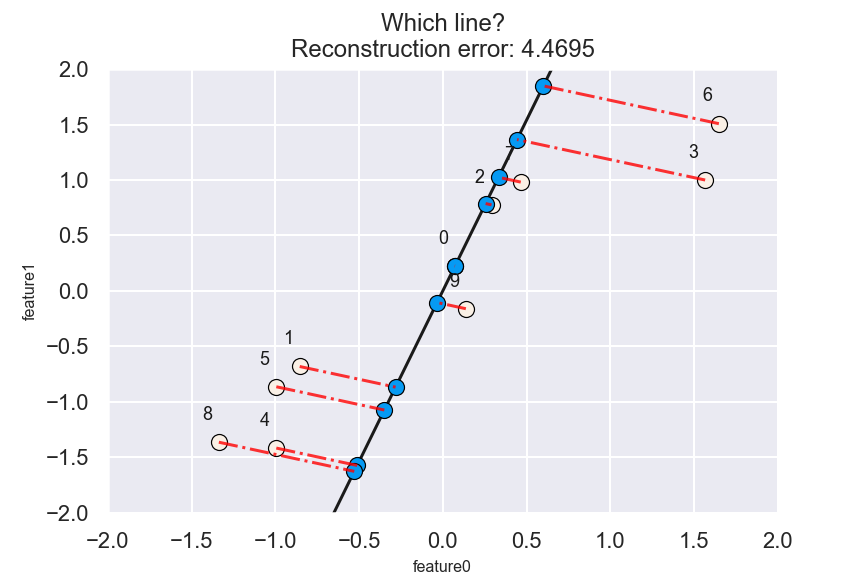
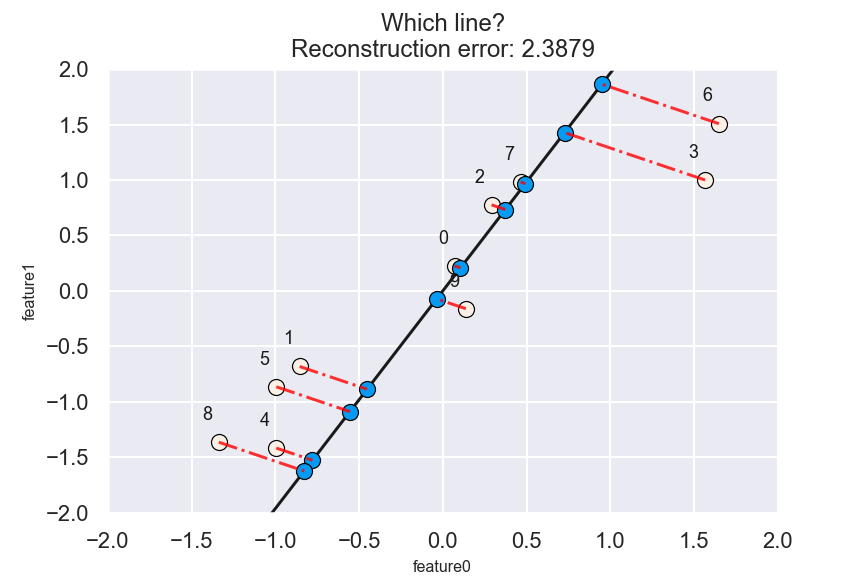
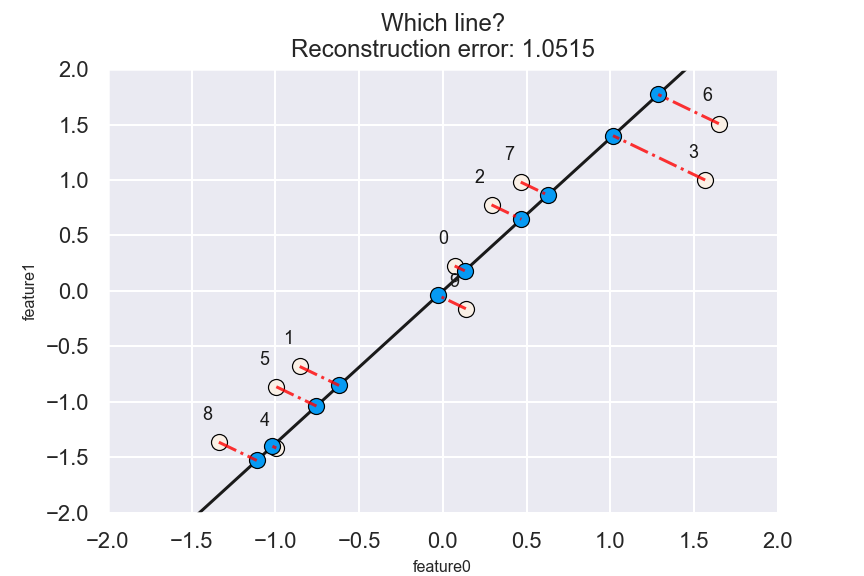
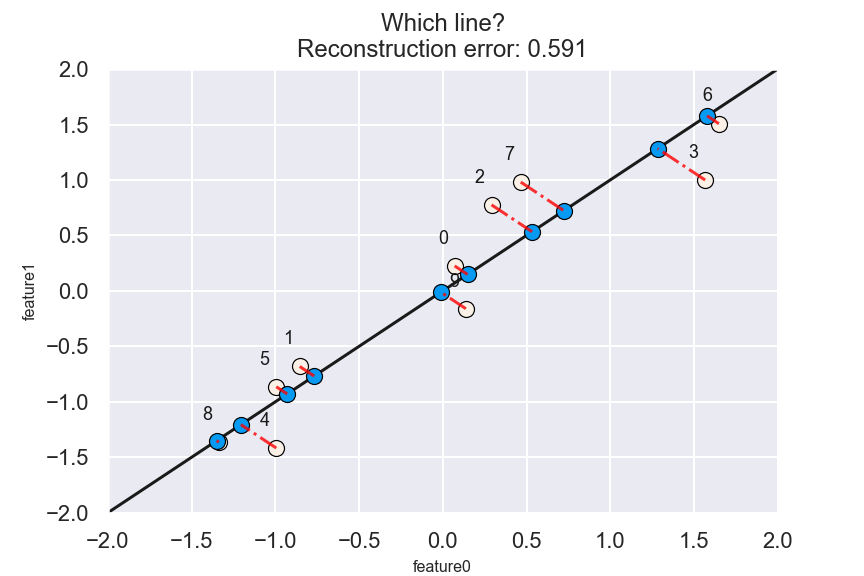
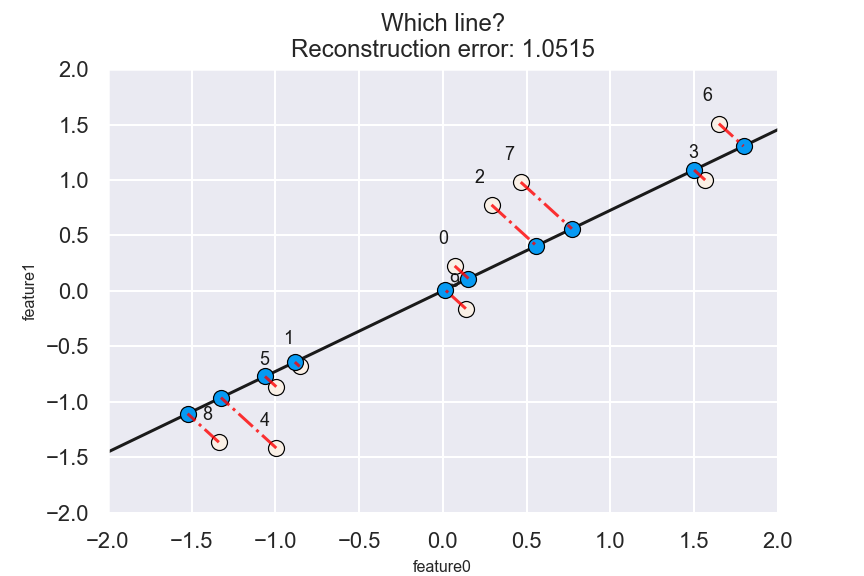
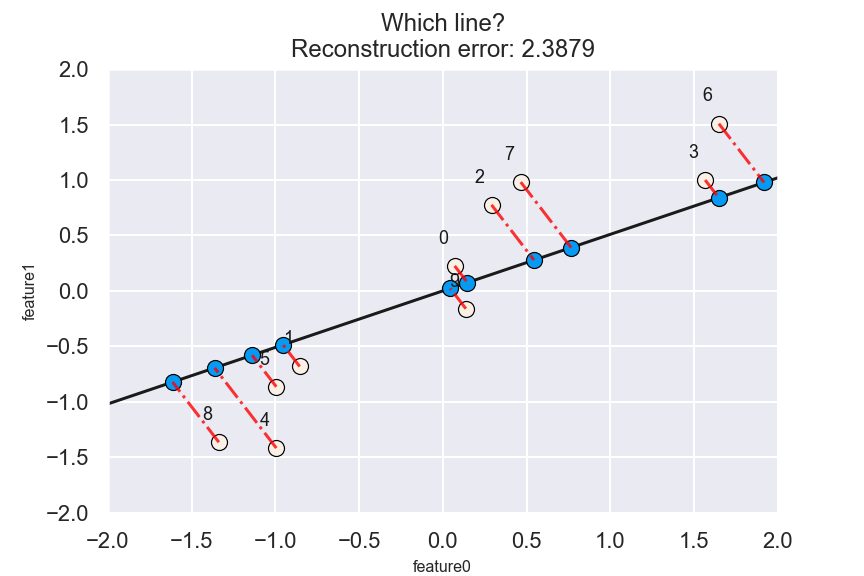
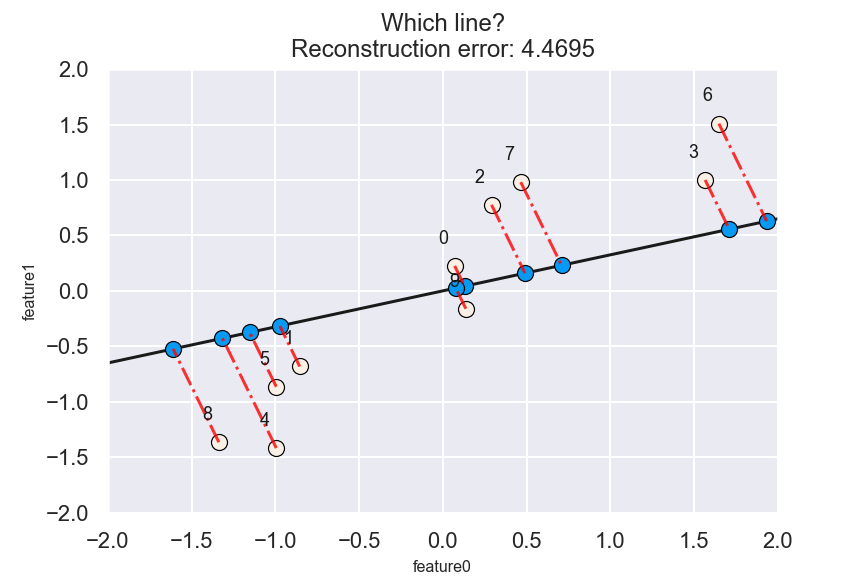
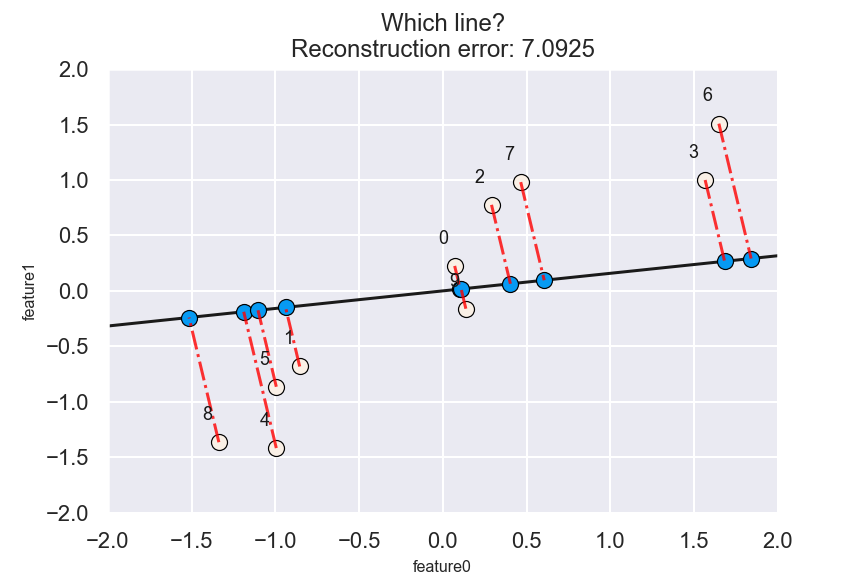
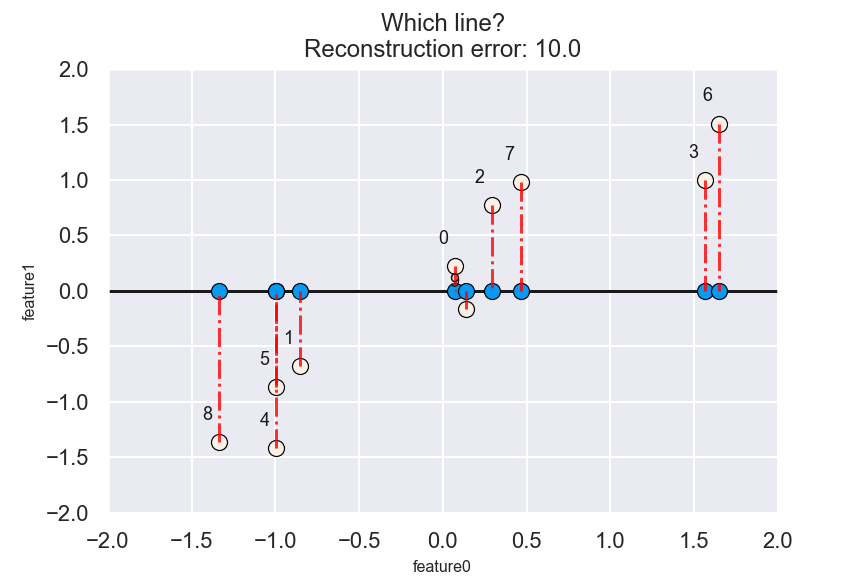

In [21]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib

pn.extension()

def f(angle):
    fig = plt.figure(figsize=(6, 4))
    return plot_pca_model_search(X, fig, alpha=angle, w=6, h=4)


#interact(f, angle=widgets.IntSlider(start=0, end=182, step=1, value=0))
interact(f, angle=widgets.IntSlider(start=0, end=182, step=1, value=0)).embed(max_opts=20)

- Reconstruction error: sum of the squared distances between original points and projected points.  
- PCA picks the direction which gives the smallest **reconstruction error**. 
- Interestingly, this is the same as **maximizes the variance of the projected points**.
- So PCA learns a linear model (e.g., lines, planes, or hyperplanes) which minimizes the "reconstruction error" or maximizes the variance of the projected points.     
- We'll look at the actual loss function later. 
- First, let's understand some terminology. 

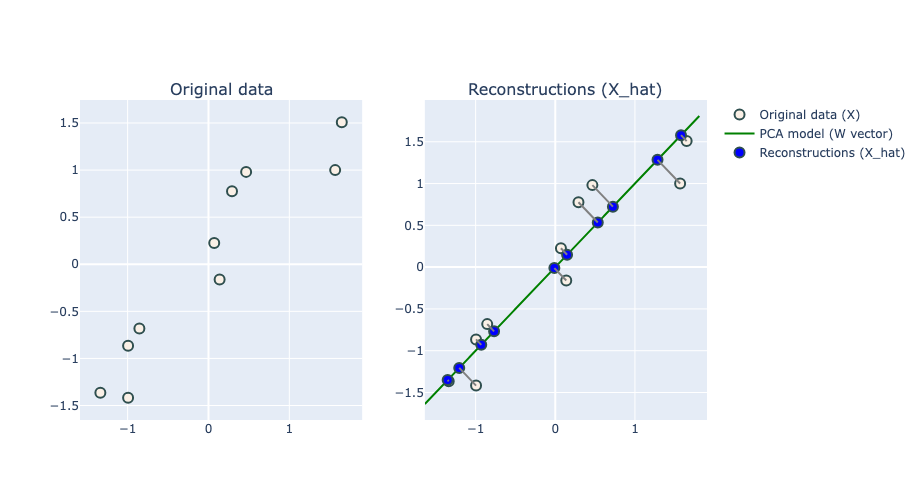

In [22]:
pca = PCA(n_components=1).fit(X)
plot_pca_reconstructions(X, pca)

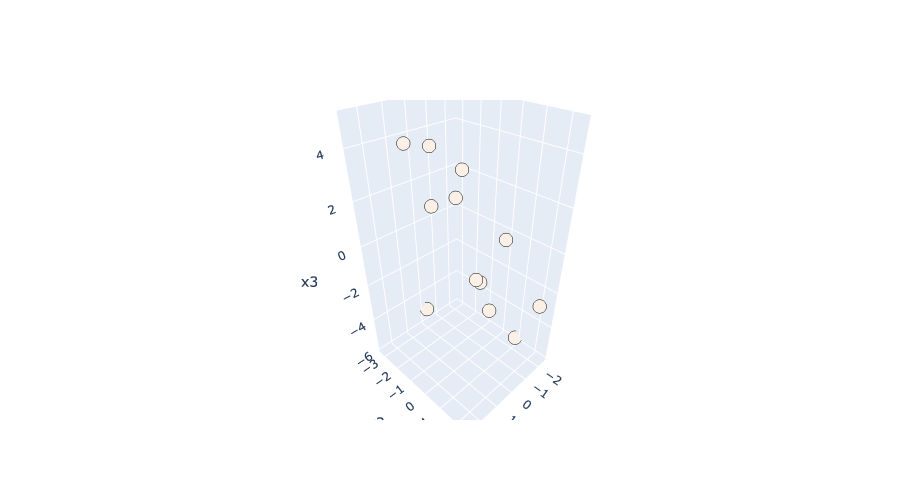

In [23]:
n = 12
d = 3

x1 = np.linspace(0, 5, n) + np.random.randn(n) * 0.05
x2 = -x1 * 0.1 + np.random.randn(n) * 2
x3 = x1 * 0.7 + np.random.randn(n) * 3

X_3d = np.concatenate((x1[:, None], x2[:, None], x3[:, None]), axis=1)
X_3d = X_3d - np.mean(X_3d, axis=0)
plot_interactive_3d(X_3d)

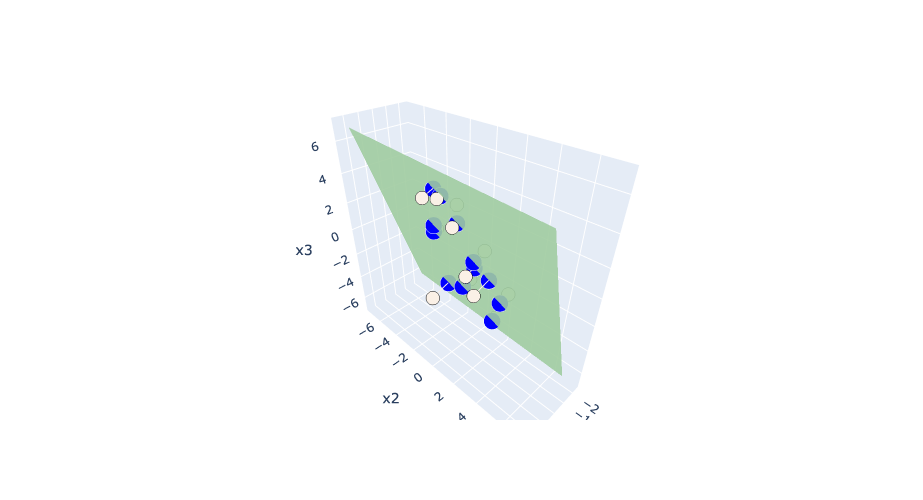

In [24]:
pca = PCA(n_components=2)
pca.fit(X_3d)
plot_3d_2k(X_3d, pca)

### PCA input/output

- Let's bring back our nutritional value of pizza dataset.  

In [25]:
X_pizza

mois   prot    fat   ash  sodium   carb   cal
0    27.82  21.43  44.87  5.11  1.77    0.77   4.93
1    28.49  21.26  43.89  5.34  1.79    1.02   4.84
2    28.35  19.99  45.78  5.08  1.63    0.80   4.95
3    30.55  20.15  43.13  4.79  1.61    1.38   4.74
4    30.49  21.28  41.65  4.82  1.64    1.76   4.67
..     ...    ...    ...   ...   ...     ...    ...
295  44.91  11.07  17.00  2.49  0.66    25.36  2.91
296  43.15  11.79  18.46  2.43  0.67    24.17  3.10
297  44.55  11.01  16.03  2.43  0.64    25.98  2.92
298  47.60  10.43  15.18  2.32  0.56    24.47  2.76
299  46.84  9.91   15.50  2.27  0.57    25.48  2.81

[300 rows x 7 columns]

In [26]:
X_pizza_scaled = StandardScaler().fit_transform(X_pizza)  # scale the data

### PCA input

In [27]:
from sklearn.decomposition import PCA

n_components = 2  # k = 2
pca = PCA(n_components=n_components)
pca.fit(X_pizza_scaled);

- A scaled matrix $X$ with $d$ dimensions (features) and $n$ examples
- Number of components $k$
   - We need to specify how many components we want to keep ($k$).
- In our case, $n=300$, $d =7$, and $k=2$   

### PCA output

Two matrices: $Z$ and $W$

- Projected data ($Z$)
- Basis vectors ($W$)

In [28]:
# Projected data Z
Z = pca.transform(X_pizza_scaled)  # transform the data
component_labels = ["PC" + str(i + 1) for i in range(n_components)]
pd.DataFrame(Z, columns=component_labels, index=X_pizza.index)

PC1       PC2
0    5.010343  2.679215
1    5.023755  2.529295
2    4.805439  2.673700
3    4.469543  2.285029
4    4.471893  2.159152
..        ...       ...
295 -0.535510 -0.530843
296 -0.339636 -0.243230
297 -0.646433 -0.515434
298 -0.865078 -0.921790
299 -0.895868 -0.767878

[300 rows x 2 columns]

In [29]:
Z.shape

(300, 2)

In [30]:
# Basis vectors W
W = pca.components_
pd.DataFrame(W, columns=X_pizza.columns, index=component_labels)

mois      prot       fat      ash    sodium      carb       cal
PC1  0.064709  0.378761  0.446666  0.47189  0.435703 -0.424914  0.244487
PC2 -0.628276 -0.269707  0.234379 -0.11099  0.201662  0.320312  0.567458

In [31]:
W.shape

(2, 7)

### Output of PCA: transformed data $Z$ 

- Suppose the original data matrix $X$ has $n$ rows and $d$ columns, and we specify the number of components as $k$. 
- $Z$: Each row of $Z$ is a set of "part weights" of "factor loadings" or "features"
    $$Z = \begin{bmatrix}
        z_{11} & \ldots & z_{1k}\\ 
        z_{21} & \ldots & z_{2k}\\ 
        & \vdots &\\
        z_{n1} & \ldots & z_{nk}
        \end{bmatrix}_{n \times k}
    $$

- It has $n$ rows and $k$ columns in contrast to $d$ columns in the original data (usually $k << d$). 

### Output of PCA: Basis vectors $W$ 
- $W$: Each row of $W$ is a set of **factors**, **principal components**, **parts**, or **basis vectors**. 
    $$W = \begin{bmatrix}
            w_{11} & \ldots & w_{1d}\\ 
            w_{21} & \ldots & z_{2d}\\ 
            & \vdots &\\
            w_{k1} & \ldots & z_{kd}
            \end{bmatrix}_{k \times d}
    $$

- We can access $W$ using `components_` attribute of the `PCA` object. 
- $W$ has $k$ rows, one for each component. 
- Each row has a coefficient or weight associated with all $d$ features. 

### Interpretation of the coefficients

- You can interpret these coefficients similar to linear regression. 
    - Higher magnitude of the coefficient means the feature has a strong effect on the corresponding principal component. 
    - Positive coefficient means the feature and the principal component are positively correlated.
    - Negative coefficient means the feature and the principal component are negatively correlated. 

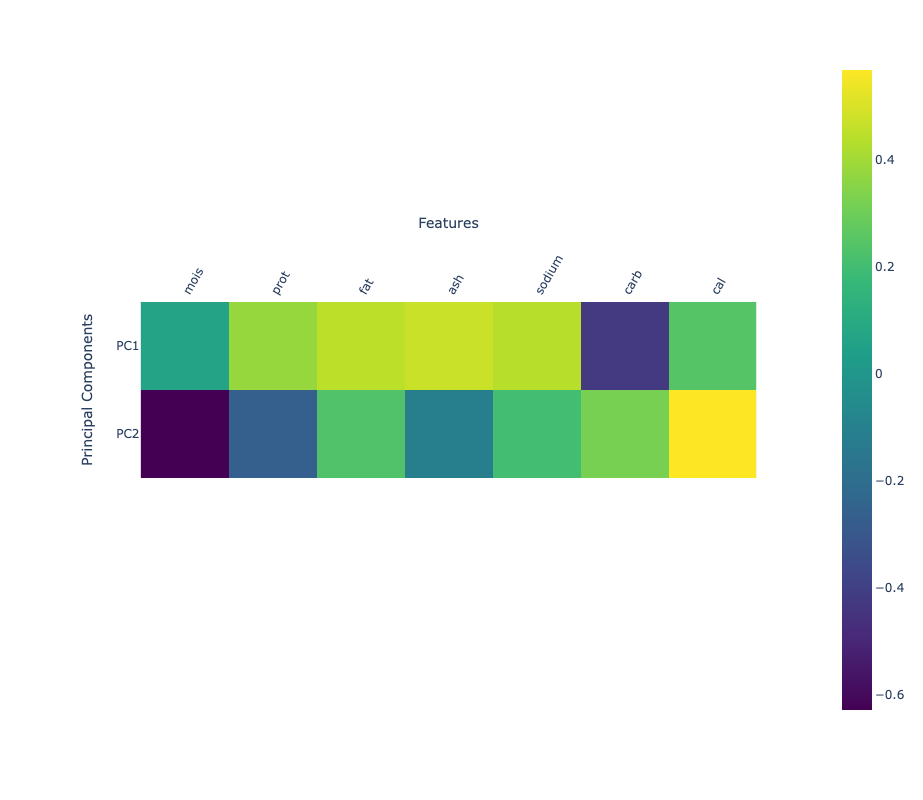

In [32]:
plot_pca_w_vectors(W, component_labels, X_pizza.columns, width=800, height=800)

### Reconstruction 

- In dimensionality reduction, unlike feature selection, we are not exactly throwing away features; we can reconstruct $X$ (with some error) by multiplying $Z$ and $W$ matrices. 

In [33]:
pd.DataFrame(Z, columns=component_labels, index=X_pizza.index)

PC1       PC2
0    5.010343  2.679215
1    5.023755  2.529295
2    4.805439  2.673700
3    4.469543  2.285029
4    4.471893  2.159152
..        ...       ...
295 -0.535510 -0.530843
296 -0.339636 -0.243230
297 -0.646433 -0.515434
298 -0.865078 -0.921790
299 -0.895868 -0.767878

[300 rows x 2 columns]

In [34]:
pd.DataFrame(W, columns=X_pizza.columns, index=component_labels)

mois      prot       fat      ash    sodium      carb       cal
PC1  0.064709  0.378761  0.446666  0.47189  0.435703 -0.424914  0.244487
PC2 -0.628276 -0.269707  0.234379 -0.11099  0.201662  0.320312  0.567458

### $\hat{X}$ in the example above 
We can reconstruct examples by multiplying $Z$ and $W$. 

In [35]:
X_pizza_hat = Z @ W

In [36]:
pd.DataFrame(X_pizza_hat, columns=X_pizza.columns).round(4)

mois    prot     fat     ash  sodium    carb     cal
0   -1.3591  1.1751  2.8659  2.0670  2.7233 -1.2708  2.7453
1   -1.2640  1.2206  2.8368  2.0899  2.6989 -1.3245  2.6635
2   -1.3689  1.0990  2.7731  1.9709  2.6329 -1.1855  2.6921
3   -1.1464  1.0766  2.5320  1.8555  2.4082 -1.1672  2.3894
4   -1.0672  1.1114  2.5035  1.8706  2.3838 -1.2086  2.3185
..      ...     ...     ...     ...     ...     ...     ...
295  0.2989 -0.0597 -0.3636 -0.1938 -0.3404  0.0575 -0.4322
296  0.1308 -0.0630 -0.2087 -0.1333 -0.1970  0.0664 -0.2211
297  0.2820 -0.1058 -0.4095 -0.2478 -0.3856  0.1096 -0.4505
298  0.5232 -0.0790 -0.6024 -0.3059 -0.5628  0.0723 -0.7346
299  0.4245 -0.1322 -0.5801 -0.3375 -0.5452  0.1347 -0.6548

[300 rows x 7 columns]

### Reconstruction using `inverse_transform`
- We can also access the reconstructed data using `inverse_transform` attribute of the PCA object. 

In [37]:
X_pizza_hat = pca.inverse_transform(Z)
pd.DataFrame(X_pizza_hat, columns=X_pizza.columns).round(4)

mois    prot     fat     ash  sodium    carb     cal
0   -1.3591  1.1751  2.8659  2.0670  2.7233 -1.2708  2.7453
1   -1.2640  1.2206  2.8368  2.0899  2.6989 -1.3245  2.6635
2   -1.3689  1.0990  2.7731  1.9709  2.6329 -1.1855  2.6921
3   -1.1464  1.0766  2.5320  1.8555  2.4082 -1.1672  2.3894
4   -1.0672  1.1114  2.5035  1.8706  2.3838 -1.2086  2.3185
..      ...     ...     ...     ...     ...     ...     ...
295  0.2989 -0.0597 -0.3636 -0.1938 -0.3404  0.0575 -0.4322
296  0.1308 -0.0630 -0.2087 -0.1333 -0.1970  0.0664 -0.2211
297  0.2820 -0.1058 -0.4095 -0.2478 -0.3856  0.1096 -0.4505
298  0.5232 -0.0790 -0.6024 -0.3059 -0.5628  0.0723 -0.7346
299  0.4245 -0.1322 -0.5801 -0.3375 -0.5452  0.1347 -0.6548

[300 rows x 7 columns]

### More formally
- We can get $\hat{X}_{n \times d}$ (reconstructed $X$) by matrix multiplication of $Z_{n \times k}$ and $W_{k \times d}$. 
$$\hat{X}_{n \times d} = Z_{n \times k}W_{k \times d} = \begin{bmatrix}
        z_{11} & \ldots & z_{1k}\\ 
        z_{21} & \ldots & z_{2k}\\ 
        & \vdots &\\
        z_{n1} & \ldots & z_{nk}
        \end{bmatrix}_{n \times k} \times 
        \begin{bmatrix}
            w_{11} & \ldots & w_{1d}\\ 
            w_{21} & \ldots & w_{2d}\\ 
            & \vdots &\\
            w_{k1} & \ldots & w_{kd}
            \end{bmatrix}_{k \times d}$$
- For instance, you can reconstruct an example $\hat{x_{i}}$ as follows:  

$$\hat{x_{i}} = \begin{bmatrix} z_{i1}w_{11} + z_{i2}w_{21} + \dots + z_{ik}w_{k1} \\ z_{i1}w_{12} + z_{i2}w_{22} + \dots + z_{ik}w_{k2}\\ \vdots\\ z_{i1}w_{1d} + z_{i2}w_{2d} + \dots + z_{ik}w_{kd}\end{bmatrix}_{d \times 1}$$

### Reconstruction error

- How good is the reconstructed data? 
- Are we able to accurately reconstruct the original data? 
- Let's compare our reconstructions to the original scaled data. 

In [38]:
pd.DataFrame(X_pizza_scaled).head(5)  # orginal scaled data

0         1         2         3         4         5         6
0 -1.371815  1.254181  2.749841  1.953894  2.976687 -1.227511  2.680129
1 -1.301562  1.227717  2.640475  2.135338  3.030779 -1.213622  2.534733
2 -1.316242  1.030010  2.851396  1.930227  2.598042 -1.225844  2.712439
3 -1.085563  1.054918  2.555660  1.701449  2.543950 -1.193622  2.373183
4 -1.091854  1.230830  2.390494  1.725116  2.625088 -1.172510  2.260097

In [39]:
pd.DataFrame(X_pizza_hat).head(5)  # reconstructions

0         1         2         3         4         5         6
0 -1.359070  1.175120  2.865901  2.066961  2.723316 -1.270778  2.745306
1 -1.264011  1.220635  2.836754  2.089930  2.698926 -1.324499  2.663512
2 -1.368864  1.098998  2.773085  1.970881  2.632927 -1.185479  2.692080
3 -1.146407  1.076601  2.531956  1.855514  2.408196 -1.167248  2.389404
4 -1.067170  1.111440  2.503502  1.870594  2.383835 -1.208566  2.318548

- Let's calculate squared distances between original data and reconstructed data. 

In [40]:
def reconstruction_error(X, X_hat):
    error = np.sum((np.array(X) - np.array(X_hat)) ** 2, axis=1)
    return error

In [41]:
recon_df = pd.DataFrame(reconstruction_error(X_pizza_scaled, X_pizza_hat))

- As we can see, the reconstruction error is different for different examples. 

In [42]:
recon_df.head(10)

0
0  0.102984
1  0.181051
2  0.018575
3  0.047858
4  0.111718
5  0.084313
6  0.071166
7  0.305112
8  0.040296
9  0.007561

- One way to summarize these distances is by looking at the mean or median reconstruction error. 

In [43]:
recon_df.median()

0    0.295413
dtype: float64

### Interim summary
- Principal Component Analysis (PCA) is one of the widely used dimensionality reduction techniques. 
- The overall idea is to project high dimensional data onto a lower dimensional space to get a new representation. 
- It applies a linear transformation on the data and so it's a **linear dimensionality reduction** technique. 
- As input it takes number of components and scaled data and as output it results in two matrices: the transformed data matrix $Z$ and the weight matrix $W$.  
- It's possible to reconstruct the original data (with some error) by multiplying $Z$ and $W$ matrices. 

<br><br><br><br>

## PCA loss function 

In the previous section we looked at
- the intuition behind PCA
- the input and output of PCA
- how it approximates data matrix $X$ by matrix-matrix product $ZW$ or in other words how it approximates each example $x_i$ by the matrix-vector product $W^Tz_i$  

- You will find a number of views and explanations for PCA.     
- One way to view PCA is that it learns the hyperplane that minimizes the reconstruction error in the least squares sense. 
- Let's get an intuition for PCA loss function. 
- Let's generate some 2D data. 

In [44]:
np.random.seed(42)
feat1 = np.random.randn(10)
feat2 = feat1 + np.random.randn(10) / 3
X_orig = pd.DataFrame(data=np.stack([feat1, feat2], axis=1), columns=["feat1", "feat2"])
X_2d = StandardScaler().fit_transform(X_orig)
data = pd.DataFrame(X_2d, columns=["feat1", "feat2"])
data.head()

feat1     feat2
0  0.070933  0.225033
1 -0.854819 -0.681970
2  0.291042  0.775871
3  1.567225  0.999754
4 -0.994618 -1.417587

It's not so interesting to reduce dimensionality from 2d to 1d but we'll do it for demonstration purpose. 

In [45]:
pca = PCA(n_components=1, random_state=42)
pca.fit(data)
Z = pca.transform(data)  # transformed data
W = pca.components_
pd.DataFrame(Z, columns=["PC1"])

PC1
0  0.209279
1 -1.086674
2  0.754422
3  1.815128
4 -1.705686
5 -1.314696
6  2.232519
7  1.022977
8 -1.910979
9 -0.016289

### PCA reconstructions

In [46]:
X_hat = pca.inverse_transform(Z)
pd.DataFrame(X_hat, columns=["recon_feat1", "recon_feat2"])

recon_feat1  recon_feat2
0  0.147983     0.147983   
1 -0.768395    -0.768395   
2  0.533457     0.533457   
3  1.283489     1.283489   
4 -1.206102    -1.206102   
5 -0.929631    -0.929631   
6  1.578629     1.578629   
7  0.723354     0.723354   
8 -1.351266    -1.351266   
9 -0.011518    -0.011518

Let's compare our reconstructions (`X_hat`) and original scaled data (`X_scaled`). 

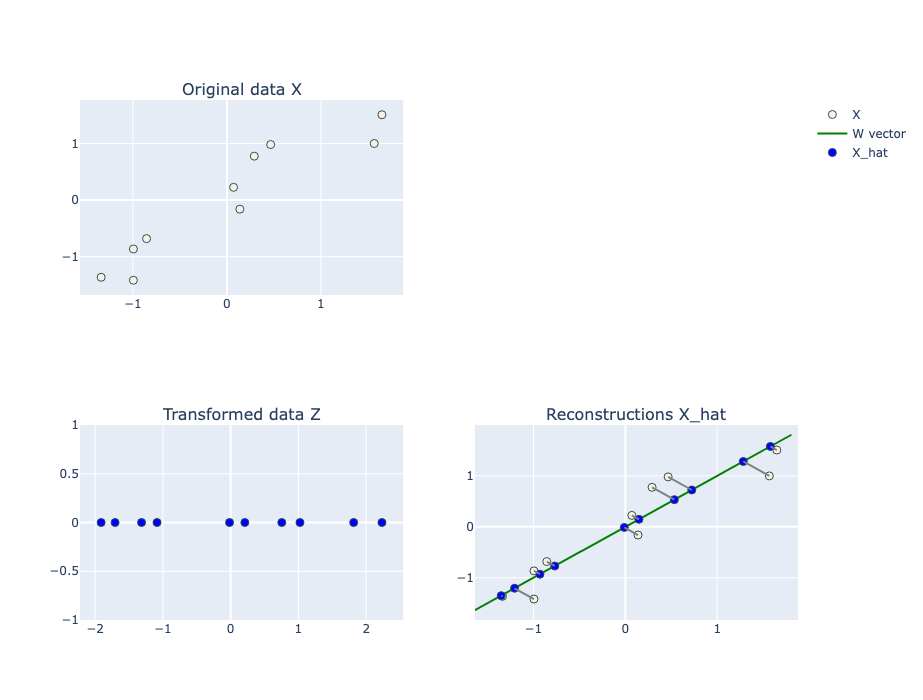

In [47]:
plot_pca_model_reconstructions(data, pca)

- In our case $d = 2$ and number of components is 1. The green line corresponds to $W_{k\times d}$ in the new 1D coordinate system.
- `X_hat` are reconstructions. 
- PCA learns an optimal line, plane, or hyperplane so that reconstruction error is minimized. 
- Goal: Minimize the sum of squared distances between blue points (original) and red points (reconstructions).  

### PCA objective function

In PCA we minimize the sum of squared error between elements of $X$ and elements of $ZW$: 

$$f(W,Z) = \sum_{i=1}^{n} \lVert{W^Tz_i - x_i}\rVert^2_2 $$

- $W^Tz_i \rightarrow$ reconstructed example 
- $x_i \rightarrow$ original example 

**Intuition**: What are the best two matrices $W$ and $Z$ we can come up with so that when we multiply them we get a matrix that's closest to the original data.   

### PCA vs. linear regression

- Minimizing squared error might remind you of linear regression.
- **BUT THEY ARE NOT THE SAME.**

- In case of linear regression, 
    - We minimize the squared error between true `y` and predicted `y_hat`. 
    - We only care about the vertical distance because our goal is to predict `y` which we represent on the y-axis.
- Unlike in regression we are also learning the features $z_i$ in PCA. 

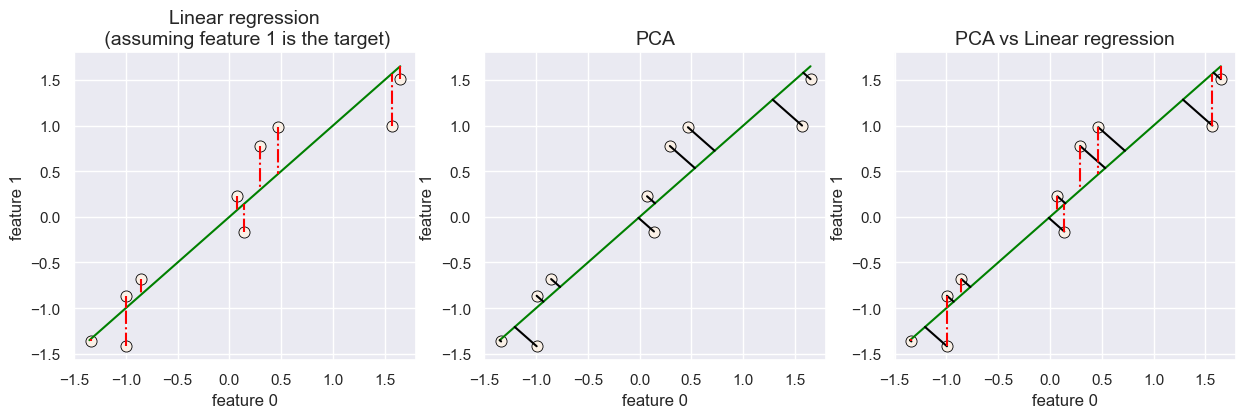

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))  
plot_pca_regression(X_2d, error_type="lm", ax=ax[0], title='Linear regression\n (assuming feature 1 is the target)')
plot_pca_regression(X_2d, error_type="pca", ax=ax[1], title='PCA')
plot_pca_regression(X_2d, error_type="both", ax=ax[2], title='PCA vs Linear regression')

### PCA algorithm 

- We want to find a transformation of the data such that we do not lose much information. In other words, 
    - we want the projections to be as close as possible to the original data
- We can use optimization algorithms to find the solution. 
- But there is a better and faster way using linear algebra! 

The standard PCA is as follows: 

- Center $X$ (subtract mean). (In practice, also scale to unit variance, i.e., apply `StandardScaler`.) 
- Compute **singular value decomposition (SVD)** of the data matrix to get principal components ($W$) and the corresponding singular values.   
- The variance captured by each principal component corresponds to the square of the **singular values**. 
- Drop principal components with smallest singular values for dimensionality reduction.  

### Singular Value Decomposition (SVD)

- Singular value decomposition decomposes the given real-valued matrix $A_{n \times d}$ into three matrices: 

$$A_{n \times d} = U_{n \times d}S_{d\times d}V^T_{d \times d}$$
- $U_{n \times d}$ has orthonormal columns 
    - $U_i^TU_j= 0$ for all $i \neq j$
- $S_{d\times d}$ is a diagonal matrix containing singular values (square roots of eigenvalues of $A^TA$ and $AA^T$)
- $V^T_{d \times d}$ is an orthogonal matrix which contains the principal components. 
    - A matrix $X$ is an orthogonal matrix if $X^{-1} = X^T$
- For dimensionality reduction we drop rows of $V^T$ and $S$ and columns of $U$. 

```{note} 
In some software (e.g., `numpy` with default parameters), if you carry out SVD, you'll notice that the shapes of $U$ and $D$ are $U_{n \times n}$ and $S_{n \times d}$. This is done by adding some padding in $U$ and $S$ in order to make $U$ orthogonal. You don't have to worry about it when you carry out dimensionality reduction. 
```

- Another popular view of PCA is that it maximizes the **variance** of the projected (transformed) points. 
- We search for the direction of highest variance.  
    - This direction is called the **first principal component**.     
    - The next direction with highest variance is the **second principal component**.
    - And so on ...

Let's look at an example. 

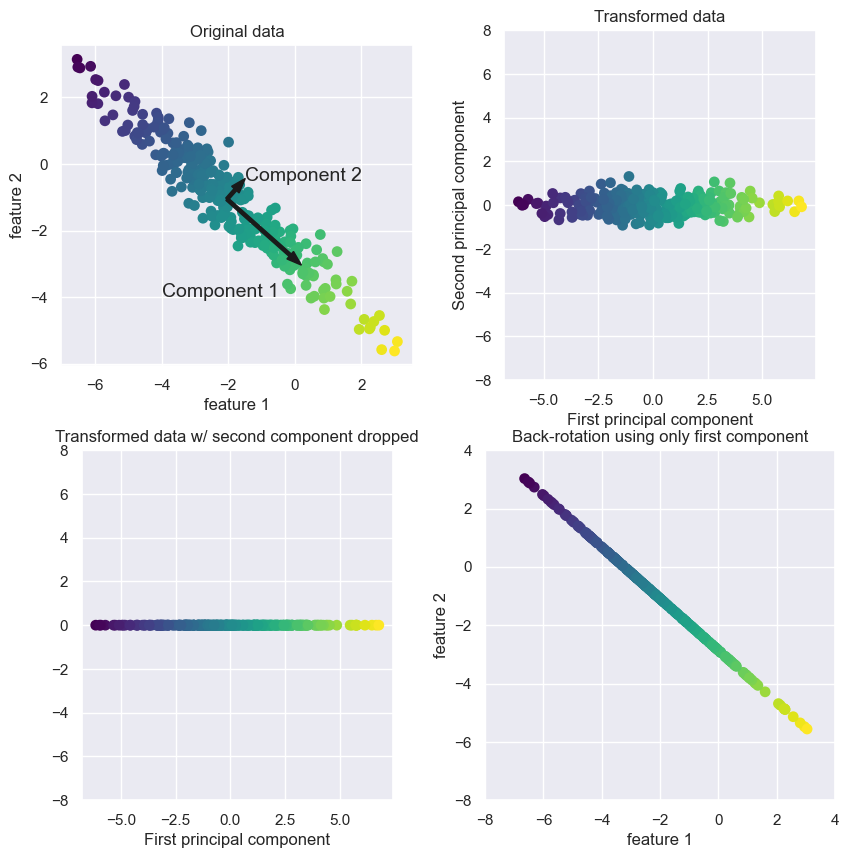

In [49]:
# source: Introduction to Machine Learning with Python book
plot_pca_illustration()
plt.show()


- Find the direction of maximum variance (Component 1). The direction with maximum variance contains most information in the data. 
- Find second direction which contains most information while being orthogonal (at right angle) to the first direction. (Component 2) 
- The head or tail of the arrows does not matter. They can point in any direction. 
- The directions found by this process are called **principal components**, as they are the directions of variance in the data. 
- There are usually as many components as the original features.
- In dimensionality reduction, we consider the first $k<<d$ most important components. 

- The top right plot shows the same data but rotated so that the first component aligns with the x-axis and the second component with the y-axis. 
- The mean is subtracted from the data before rotation so that the data is centered around zero. 
- In the bottom left plot, we are reducing dimensions from two dimensions to one dimensions. 
- We are keeping the most interesting direction with maximum variance (component 1). 
- In the bottom right plot we undo the rotation and add the mean back to the data. This is our reconstruction of the data. 

### General idea 

- We want to find a transformation such that the transformed features are statistically uncorrelated. 
- We find new axes/basis vectors (rows of $W$) which are mutually orthogonal.
- Each axis has eigenvalues which correspond to the variance in that direction and they decrease monotonically. 
- Since the eigenvalues decrease monotonically for our axes, once we are in the new space, we can drop the the axes with smallest eigenvalues for dimensionality reduction.   

### (Optional) Uniqueness of PCA solution

- SVD gives us a solution with the following constraints to make it close to unique.     
    - Normalization: we enforce that $\lVert w_c \rVert = 1$
    - Orthogonality: we enforce that $w_c^T.w_{c'}= 0$ for all $c \neq c'$
    - Sequential fitting: 
        - We first fit $w_1$ ("first principal component") giving a line.
        - Then fit $w_2$ given $w_1$ ("second principal component") giving a plane.
        - Then we fit $w_3$ given $w_1$ and $w_2$ ("third principal component") giving a hyperplane and so on 

Even with all this, the solution is only unique up to sign changes. 

<br><br><br><br>

## ❓❓ Questions for you

### 3.1 Select all of the following statements which are **True** (iClicker)

**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) Each principal component of PCA is $d$ dimensional, where $d$ is the dimensionality of the original data.   
- (B) In PCA, the first principal component is always the one with highest variance in the data.
- (C) When $k=d$, $Z$ will be exactly the same as $X$.  
- (D) When $k=d$, $X_{hat}$ will be exactly the same as $X$.
- (E) In PCA, it's best to pick $k$ as the largest value so that we capture most of the variance in the data.

<br><br><br><br>

```{admonition} V's Solutions!
:class: tip, dropdown
- A, B, D
```

### 3.2 Select all of the following statements which are **True** (iClicker)

**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) If you are reducing dimensionality from $d$ dimensions to $k$ dimensions using PCA, where $k\leq d$, then your model is a $k$ dimensional hyperplane. 
- (B) PCA assumes that the variables in the dataset are not correlated.
- (C) In PCA, it's possible to identify the most dominant features associated with each principal components.
- (D) Since PCA and linear regression both minimize squared error, PCA can be thought of as an unsupervised alternative for linear regression. 

<br><br><br><br>

```{admonition} V's Solutions!
:class: tip, dropdown
- A, C
```

### Discussion questions
- Why is PCA causing loss of information? Is it possible to use PCA without loss of information?
- Do we need to scale the features before applying PCA? 

<br><br><br><br>

Check out [the class demo](class_demo/03_class-demo.ipynb). 

## Final comments, summary, and reflection 

### Take-home message

- **Dimensionality reduction** is the task of reducing a dataset in high dimension to low dimension **while retaining the most "important" characteristics of the data.** 
- PCA is one of the most widely used linear dimensionality reduction techniques. 
- Given data matrix $X_{n \times d}$ and number of components $k \leq d$, PCA outputs transformed data $Z_{n \times k}$ and weight matrix $W_{k \times d}$.
- When going from higher dimensional space to lower dimensional space, PCA still tries to capture the topology of the points in high dimensional space, making sure  that we are not losing some of the important properties of the data. 
- So Points which are nearby in high dimensions are still nearby in low dimension. 

- PCA reduces the dimensionality by learning a $k$-dimensional subspace of the original $d$-dimensional space.
- To represent $k$-dimensional subspace we need $k$ basis vectors. 
    - Each basis vector or a principal component is $d$ dimensional. 
    - The basis vectors or principal components are the rows of $W$. 
        - So PCA learns $k$ basis vectors which define the transformations.        
    - The representation in the new basis are the columns of $Z$.    

- These principal components are basis vectors in the direction of maximum variance.
- The basis vectors are orthogonal to each other. 
- Once we have $W$ we can obtain our transformed data points as a weighted sum of these components. 
    - $Z_{(n\times k)} = X_{(n\times d)}W^T_{(d\times k)}$
- We can also apply **inverse transformation** to recover $X$ from $Z$:
    - $X_{(n\times d)} \approx Z_{(n\times k)}W_{(k\times d)}$ 
    - if $k=d$, then $\approx$ becomes $=$ (i.e., you can precisely recover $X$)    

- In PCA, we minimize the squared error of reconstruction, i.e., elements of `X` and elements of `ZW`. 
- The goal is to find the two best matrices such that when we multiply them we get a matrix that's closest to the data. 
- A common way to learn PCA is using singular value decomposition (SVD), which is a tool to decompose matrix $A_{n\times d}$ as $U_{n \times d}\Sigma_{d \times d} V^T_{d \times d}$. 
- We apply dimensionality reduction and consider only $k$ dimensions ($k<<d$) making the shapes of the matrices as: $U_{n \times k}\Sigma_{k \times k} V^T_{k \times d}$.   
- $V^T$ corresponds to $W$ and $U_{n \times k}\Sigma_{k \times k}$ corresponds to transformed data $Z$. 
- We can access the variance explained by each component using `sklearn`'s `explained_variance_` and `explained_variance_ratio_`. 

### PCA applications

- PCA is useful in a number of applications. Some examples include
    - Visualization 
    - Feature extraction
    - Anomaly detection

### Reflection (~4 mins)

- PCA is a difficult concept to teach and to learn. But it's one of the most important ideas in machine learning and data science. It's fine if you did not understand all the moving pieces in the first pass. Take your time but make sure you understand the intuition behind the main ideas discussed in this lecture.  

<br><br><br><br>

## Resources

- [Introduction to Machine Learning with Python book Chapter 3](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch03.html)
- [PCA visualization](https://setosa.io/ev/principal-component-analysis/)
- [Eigen vectors and eigen values visualization](https://setosa.io/ev/eigenvectors-and-eigenvalues/)
- [StatQuest PCA video](https://www.youtube.com/watch?v=FgakZw6K1QQ&feature=youtu.be)